In [1]:
path = 'D:/Salve_Aqui_Seus_Arquivos/carlos_araujo/TETI/datasets/potato_chips/'

In [2]:
import os
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import keras

In [3]:
num_classes = 2

In [4]:
modelo_base = ResNet50(weights='imagenet', include_top = False,
                      input_shape=(224,224,3))

94765736/94765736 [==============================] - 10s 0us/step


In [5]:
modelo_novo = modelo_base.output
modelo_novo = GlobalAveragePooling2D()(modelo_novo)
modelo_novo = Dense(1024, activation = 'relu')(modelo_novo)
preds = Dense(num_classes, activation = 'softmax')(modelo_novo)

In [6]:
modelo = Model(inputs= modelo_base.input, outputs=preds)

In [7]:
for layer in modelo_base.layers:
    layer.trainable = False

In [8]:
modelo.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
modelo.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [10]:
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [11]:
validation_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [41]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(path, 'Train'),
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 769 images belonging to 2 classes.


In [54]:
validation_generator = validation_datagen.flow_from_directory(
    os.path.join(path, 'Test'),
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical',
    seed = 0
)

Found 176 images belonging to 2 classes.


In [14]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img

In [15]:
rotulos_classes = list(validation_generator.class_indices.keys())

In [16]:
def classifica(imagem):
    img = load_img(imagem, target_size=(224,224))
    img_ = image.img_to_array(img)
    img_ = np.expand_dims(img_, axis= 0)
    img_ = preprocess_input(img_)
    preds = modelo.predict(img_)
    classe_predita = np.argmax(preds, axis=1)[0]
    rotulo_predito = rotulos_classes[classe_predita]
    print(f"Classe predita: {rotulo_predito} - {preds[0][classe_predita]:.4f}")

In [17]:
path2 = 'D:/Salve_Aqui_Seus_Arquivos/carlos_araujo/TETI/amostras/'
img = (path2+ 'batata2.jpg')

In [18]:
classifica(img)

1/1 [==============================] - 4s 4s/step
Classe predita: Not Defective - 0.7735


In [19]:
rotulos_classes

['Defective', 'Not Defective']

In [20]:
modelo = keras.models.load_model(path+ 'transfer_learning_data_augm_resnet50_10epochs_potato.keras')

In [25]:
for layer in modelo_base.layers[-10]:
    layer.trainable = True
    
modelo.compile(optimizer=Adam(learning_rate=1e-5),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history = modelo.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = validation_generator,
    valiadtion_steps = validation_generator.samples // validation_generator.batch_size,
    epochs = 5
)

TypeError: 'Conv2D' object is not iterable

In [55]:
val_loss, val_accuracy = modelo.evaluate(validation_generator)
print(f'Erro na validação:{val_loss}')
print(f'Acurácia na validação:{val_accuracy}')

6/6 [==============================] - 19s 3s/step - loss: 0.0063 - accuracy: 0.9943
Erro na validação:0.006270179525017738
Acurácia na validação:0.9943181872367859


In [56]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [57]:
validation_generator.reset()

In [58]:
y_true = []
y_preds = []

In [59]:
for _ in range(len(validation_generator)):
    x_batch, y_batch = validation_generator.next()

    preds = modelo.predict_on_batch(x_batch)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_preds.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_preds = np.array(y_preds)

In [60]:
rotulos_classes = list(validation_generator.class_indices.keys())

In [61]:
resultado = classification_report(y_true, y_preds, target_names = rotulos_classes)
print('classification report:', resultado)

classification report:                precision    recall  f1-score   support

    Defective       1.00      0.99      0.99        84
Not Defective       0.99      1.00      0.99        92

     accuracy                           0.99       176
    macro avg       0.99      0.99      0.99       176
 weighted avg       0.99      0.99      0.99       176



In [63]:
matrix_conf = confusion_matrix(y_true, y_preds)

<function matplotlib.pyplot.show(close=None, block=None)>

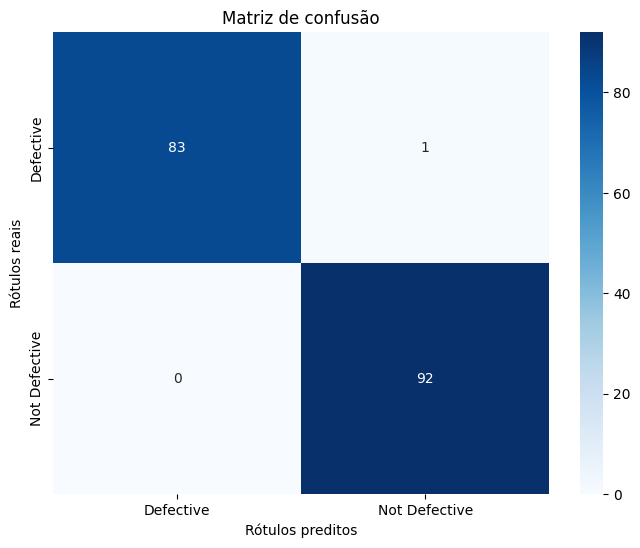

In [66]:
plt.figure(figsize=(8,6))
sns.heatmap(matrix_conf, annot= True, fmt = 'd', cmap = 'Blues',
           xticklabels = rotulos_classes, yticklabels = rotulos_classes)
plt.title('Matriz de confusão')
plt.ylabel('Rótulos reais')
plt.xlabel('Rótulos preditos')
plt.show

In [68]:
erro_predicao = np.where(y_true != y_preds)[0]

In [70]:
erro_predicao

array([117], dtype=int64)

In [ ]:
for idx in erro_predicao[:5]:
    img, label  = validation_generator[idx]
    plt.imshow(img[0].astype('uint8'))
    plt.title(f'Real: {rotulos_classe[y_true[idx]]},\
            Predito:{rotulos_classe[y_preds[idx]]}')
    